<a href="https://colab.research.google.com/github/ikhdaaakmalia/cloud/blob/main/131_GoogleSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data lokasi yang ditemukan:
                                                 Nama  \
0                                 Masjid Ngadinegaran   
1                                 Masjid Babul Jannah   
2                                   Masjid Komaruddin   
3                                    Masjid Kadipaten   
4                           Masjid An-Nur, Delingsari   
5                                masjid Agung gamping   
6                                    Masjid Al-Fattah   
7                                       Masjid Diklat   
8                       Masjid Pondok Taruna Al Quran   
9                          Masjid Taslim Tegalkenongo   
10                                  Masjid Darussalam   
11                         Masjid Pangeran Diponegoro   
12                                     Masjid Al Aman   
13                                   Masjid Ar-Rohmah   
14                    Masjid An-Nurrahman Gumuk Indah   
15                            Masjid Baitul A'la LDII   
16 

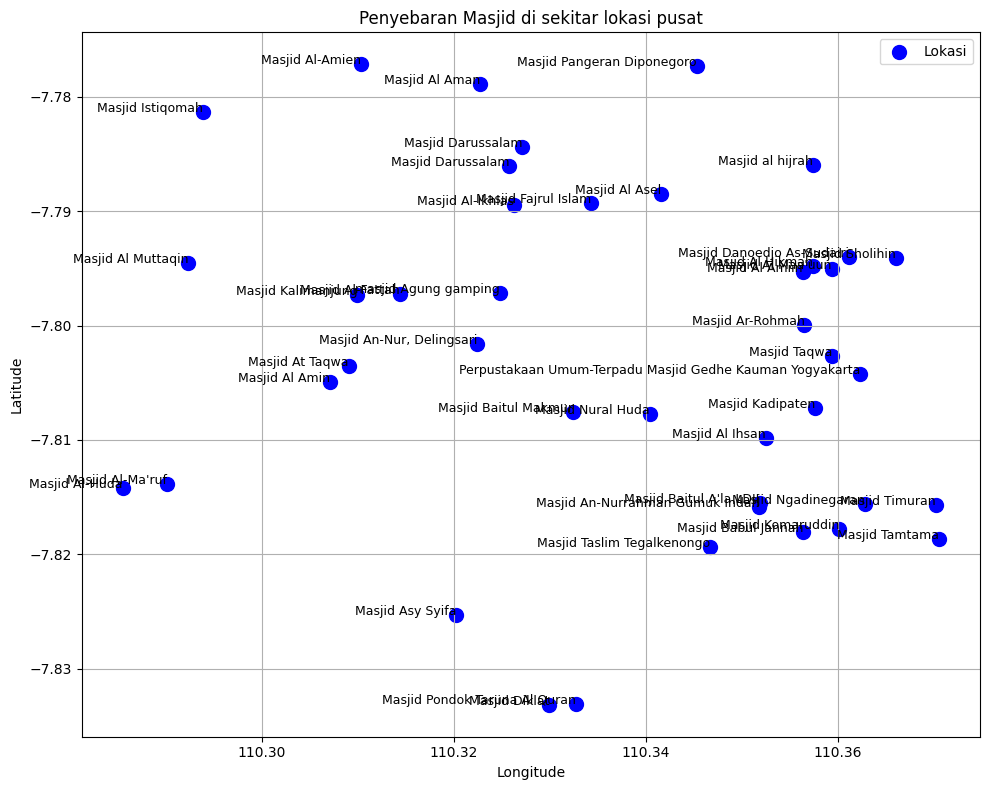

In [ ]:
# Install library
!pip install google-search-results folium geopy haversine

import requests
import pandas as pd
from haversine import haversine, Unit
import folium
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display, HTML

# ========== STEP 1: INPUT ==========
query = "MASJID"
location_coords = (-7.8125107, 110.3262286)
reference_point_name = "Pusat"
search_radius_meters = 5000


# Validasi koordinat manual
if not (-90 <= location_coords[0] <= 90 and -180 <= location_coords[1] <= 180):
    print("Koordinat tidak valid. Gunakan koordinat default.")
    location_coords = (0, 0)

# ========== STEP 2: PENGAMBILAN DATA DARI OVERPASS API ==========
def fetch_places_overpass(query, reference_coords, radius=10000):
    overpass_url = "http://overpass-api.de/api/interpreter"
    lat, lon = reference_coords

    # Query Overpass: cari node yang punya tag name matching query dalam radius
    query_osm = f"""
    [out:json];
    node(around:{radius},{lat},{lon})[name~"{query}", i];
    out body;
    """

    try:
        response = requests.get(overpass_url, params={'data': query_osm})
        response.raise_for_status()
        data = response.json()

        results = []
        for element in data.get("elements", []):
            tags = element.get("tags", {})
            name = tags.get("name", "Tanpa Nama")
            lat = element["lat"]
            lon = element["lon"]
            distance = haversine(reference_coords, (lat, lon), unit=Unit.KILOMETERS)
            results.append([
                name,
                f"Koordinat: ({lat}, {lon})",  # Karena alamat lengkap tidak tersedia dari OSM dengan mudah
                lat,
                lon,
                round(distance, 2)
            ])

        df = pd.DataFrame(results, columns=["Nama", "Alamat", "Latitude", "Longitude", "Jarak_dari_Pusat_km"])
        return df
    except requests.exceptions.RequestException as e:
        print(f"Error accessing Overpass API: {e}")
        return pd.DataFrame()

# Ambil data
df = fetch_places_overpass(query, location_coords, radius=search_radius_meters)

if df.empty:
    print("Tidak ada data yang ditemukan. Periksa query atau coba ulang.")
else:
    print("Data lokasi yang ditemukan:")
    print(df)

    # ========== STEP 3: HITUNG JARAK ANTAR LOKASI ==========
    jarak_list = []
    for (i1, row1), (i2, row2) in combinations(df.iterrows(), 2):
        coord1 = (row1['Latitude'], row1['Longitude'])
        coord2 = (row2['Latitude'], row2['Longitude'])
        distance_km = haversine(coord1, coord2, unit=Unit.KILOMETERS)
        jarak_list.append({
            "Dari": row1['Nama'],
            "Ke": row2['Nama'],
            "Jarak (km)": round(distance_km, 2)
        })

    df_jarak = pd.DataFrame(jarak_list)
    print("\nJarak antar lokasi (sampel 5 baris):")
    print(df_jarak.head())

    # ========== STEP 4: VISUALISASI DI PETA DENGAN FOLIUM ==========
    map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
    peta = folium.Map(location=map_center, zoom_start=13)

    # Titik pusat
    folium.Marker(
        location=location_coords,
        popup=f"{reference_point_name}",
        tooltip=reference_point_name,
        icon=folium.Icon(color="green", icon="star")
    ).add_to(peta)

    # Lokasi lainnya
    for _, row in df.iterrows():
        distance = row["Jarak_dari_Pusat_km"]
        icon_color = "blue" if distance <= 5 else "red"
        folium.Marker(
            location=[row["Latitude"], row["Longitude"]],
            popup=f"{row['Nama']}<br>{row['Alamat']}<br>Jarak: {distance} km",
            tooltip=row["Nama"],
            icon=folium.Icon(color=icon_color, icon="info-sign")
        ).add_to(peta)

    # Legenda
    legend_html = f"""
    <div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white;
        padding: 10px; border: 2px solid grey; border-radius: 5px;">
        <strong>Legenda:</strong><br>
        <i class="fa fa-map-marker"style="color:blue"></i> Dekat Pusat (≤ 5 km)<br>
        <i class="fa fa-map-marker" style="color:red"></i> Jauh dari Pusat (> 5 km)<br>
        <i class="fa fa-star" style="color:green"></i> {reference_point_name}
    </div>
    """
    peta.get_root().html.add_child(folium.Element(legend_html))

    # Simpan
    peta.save("peta_lokasi.html")
    print("Peta telah disimpan sebagai 'peta_lokasi.html'.")

    # Tampilkan langsung (jika di Jupyter/Colab)
    display(HTML(peta._repr_html_()))

    # ========== STEP 5: VISUALISASI MATPLOTLIB ==========
    plt.figure(figsize=(10, 8))
    plt.scatter(df["Longitude"], df["Latitude"], c='blue', s=100, label='Lokasi')
    for i, row in df.iterrows():
        plt.text(row["Longitude"], row["Latitude"], row["Nama"], fontsize=9, ha='right')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Penyebaran {query.capitalize()} di sekitar lokasi pusat")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()